# 03 - Association Rule Mining

This notebook performs market basket analysis to find products frequently bought together.

## Objectives
- Prepare transaction data for association rule mining
- Apply Apriori algorithm
- Apply FP-Growth algorithm (optional)
- Generate association rules
- Calculate support, confidence, and lift metrics
- Visualize product associations
- Interpret rules for business insights

## Phase 2 Requirements
- ✅ Run Apriori/FPGrowth algorithms
- ✅ Generate association rules
- ✅ Basic interpretation of top rules
- ⚠️ Full analysis in Phase 3


In [8]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("ASSOCIATION RULE MINING - MARKET BASKET ANALYSIS")
print("=" * 80)

# Load preprocessed data (assuming df is available from preprocessing notebook)
# If running standalone, load the cleaned dataset
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
data_path = os.path.join(project_root, 'data', 'raw', 'Online Retail.csv')

# Load and basic clean
df = pd.read_csv(data_path, encoding='latin-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Remove canceled orders
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df[df['Description'].notna()]

print(f"\nDataset loaded: {df.shape[0]:,} transactions")
print(f"Unique invoices: {df['InvoiceNo'].nunique():,}")
print(f"Unique products: {df['Description'].nunique():,}")

ASSOCIATION RULE MINING - MARKET BASKET ANALYSIS

Dataset loaded: 530,104 transactions
Unique invoices: 19,960
Unique products: 4,026


## Step 1: Prepare Transaction Data

Convert transaction data into format suitable for association rule mining.


In [9]:
# Prepare transaction data
df_association = df[['InvoiceNo', 'Description']].copy()
df_association.dropna(subset=['Description'], inplace=True)
df_association['Description'] = df_association['Description'].str.strip()
df_association = df_association[df_association['Description'] != '']

# Group items by invoice to create baskets
basket = df_association.groupby('InvoiceNo')['Description'].apply(list).reset_index()
basket.columns = ['InvoiceNo', 'Items']

print(f"Total baskets (invoices): {len(basket):,}")
print(f"Average items per basket: {basket['Items'].apply(len).mean():.2f}")
print(f"Median items per basket: {basket['Items'].apply(len).median():.2f}")

# Display sample baskets
print("\nSample Baskets:")
display(basket.head(10))

# Convert to list of lists format for TransactionEncoder
transactions = basket['Items'].tolist()
print(f"\nTotal transactions prepared: {len(transactions):,}")


Total baskets (invoices): 19,960
Average items per basket: 26.56
Median items per basket: 15.00

Sample Baskets:


,InvoiceNo,Items
0,536365,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
1,536366,"[HAND WARMER UNION JACK, HAND WARMER RED POLKA..."
2,536367,"[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO..."
3,536368,"[JAM MAKING SET WITH JARS, RED COAT RACK PARIS..."
4,536369,[BATH BUILDING BLOCK WORD]
5,536370,"[ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI..."
6,536371,[PAPER CHAIN KIT 50'S CHRISTMAS]
7,536372,"[HAND WARMER RED POLKA DOT, HAND WARMER UNION ..."
8,536373,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
9,536374,[VICTORIAN SEWING BOX LARGE]



Total transactions prepared: 19,960


## Step 2: Encode Transactions

Use TransactionEncoder to convert transaction lists into binary matrix format required by Apriori/FPGrowth.


In [10]:
# Encode transactions into binary matrix
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded matrix shape: {df_encoded.shape}")
print(f"Total unique items: {len(te.columns_)}")
print(f"\nSample of encoded matrix (first 5 rows, first 10 columns):")
display(df_encoded.iloc[:5, :10])

# Check sparsity
sparsity = 1 - df_encoded.sum().sum() / (df_encoded.shape[0] * df_encoded.shape[1])
print(f"\nMatrix sparsity: {sparsity:.2%} (typical for retail data)")


Encoded matrix shape: (19960, 4015)
Total unique items: 4015

Sample of encoded matrix (first 5 rows, first 10 columns):


,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False



Matrix sparsity: 99.35% (typical for retail data)


## Step 3: Frequent Itemset Mining - Apriori Algorithm

Apply Apriori algorithm to find frequent itemsets with minimum support threshold.


In [11]:
# Apply Apriori algorithm
# Start with a conservative support threshold (0.01 = 1% of transactions)
min_support = 0.01
print(f"Applying Apriori algorithm with min_support = {min_support} ({min_support*100}%)")

frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True, verbose=1)

print(f"\nFrequent itemsets found: {len(frequent_itemsets):,}")
print(f"\nTop 10 frequent itemsets by support:")
display(frequent_itemsets.nlargest(10, 'support'))

# Analyze itemset sizes
frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(len)
print(f"\nItemset size distribution:")
print(frequent_itemsets['itemset_length'].value_counts().sort_index())


Applying Apriori algorithm with min_support = 0.01 (1.0%)
Processing 615 combinations | Sampling itemset size 5 43

Frequent itemsets found: 1,902

Top 10 frequent itemsets by support:


,support,itemsets
776,0.113026,(WHITE HANGING HEART T-LIGHT HOLDER)
343,0.104659,(JUMBO BAG RED RETROSPOT)
555,0.099599,(REGENCY CAKESTAND 3 TIER)
462,0.084419,(PARTY BUNTING)
383,0.078357,(LUNCH BAG RED RETROSPOT)
49,0.072896,(ASSORTED COLOUR BIRD ORNAMENT)
624,0.069389,(SET OF 3 CAKE TINS PANTRY DESIGN)
441,0.066132,(PACK OF 72 RETROSPOT CAKE CASES)
375,0.063778,(LUNCH BAG BLACK SKULL.)
415,0.062575,(NATURAL SLATE HEART CHALKBOARD)



Itemset size distribution:
itemset_length
1    809
2    841
3    233
4     18
5      1
Name: count, dtype: int64


## Step 4: Generate Association Rules

Generate association rules from frequent itemsets and calculate metrics (confidence, lift, conviction).


In [12]:
# Generate association rules
# Filter for rules with minimum confidence
min_confidence = 0.3
print(f"Generating association rules with min_confidence = {min_confidence} ({min_confidence*100}%)")

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"\nAssociation rules generated: {len(rules):,}")
print(f"\nRules columns: {rules.columns.tolist()}")

# Display top rules by different metrics
print("\n" + "=" * 80)
print("TOP 10 RULES BY LIFT (Strongest Associations)")
print("=" * 80)
top_lift = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction']]
for idx, row in top_lift.iterrows():
    print(f"\nRule {idx+1}:")
    print(f"  If customer buys: {', '.join(list(row['antecedents']))}")
    print(f"  Then likely to buy: {', '.join(list(row['consequents']))}")
    print(f"  Support: {row['support']:.3f} ({row['support']*100:.1f}%)")
    print(f"  Confidence: {row['confidence']:.3f} ({row['confidence']*100:.1f}%)")
    print(f"  Lift: {row['lift']:.3f} (rule is {row['lift']:.1f}x more likely than random)")
    print(f"  Conviction: {row['conviction']:.3f}")

display(top_lift)


Generating association rules with min_confidence = 0.3 (30.0%)

Association rules generated: 1,825

Rules columns: ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'representativity', 'leverage', 'conviction', 'zhangs_metric', 'jaccard', 'certainty', 'kulczynski']

TOP 10 RULES BY LIFT (Strongest Associations)

Rule 1063:
  If customer buys: HERB MARKER PARSLEY, HERB MARKER ROSEMARY
  Then likely to buy: HERB MARKER THYME
  Support: 0.010 (1.0%)
  Confidence: 0.944 (94.4%)
  Lift: 79.519 (rule is 79.5x more likely than random)
  Conviction: 17.704

Rule 1064:
  If customer buys: HERB MARKER THYME
  Then likely to buy: HERB MARKER PARSLEY, HERB MARKER ROSEMARY
  Support: 0.010 (1.0%)
  Confidence: 0.857 (85.7%)
  Lift: 79.519 (rule is 79.5x more likely than random)
  Conviction: 6.896

Rule 1061:
  If customer buys: HERB MARKER THYME, HERB MARKER PARSLEY
  Then likely to buy: HERB MARKER ROSEMARY
  Support: 0.010 (1.0%)
  Confid

,antecedents,consequents,support,confidence,lift,conviction
1062,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010170,0.944186,79.518791,17.703929
1063,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.010170,0.856540,79.518791,6.895504
1060,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010170,0.953052,79.262128,21.043888
1065,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.010170,0.845833,79.262128,6.417267
1055,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER ROSEMARY),0.010020,0.952381,79.206349,20.747495
1058,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.010020,0.833333,79.206349,5.936874
1056,"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",(HERB MARKER THYME),0.010020,0.934579,78.709728,15.104216
1057,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",0.010020,0.843882,78.709728,6.336730
292,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011072,0.932489,77.552039,14.634394
293,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011072,0.920833,77.552039,12.481595


## Step 5: Rule Analysis and Interpretation

Analyze and interpret association rules for business insights.


In [13]:
# Rule statistics
print("=" * 80)
print("ASSOCIATION RULES SUMMARY STATISTICS")
print("=" * 80)

print(f"\nTotal Rules: {len(rules):,}")
print(f"\nSupport Statistics:")
print(f"  Mean: {rules['support'].mean():.4f}")
print(f"  Median: {rules['support'].median():.4f}")
print(f"  Min: {rules['support'].min():.4f}")
print(f"  Max: {rules['support'].max():.4f}")

print(f"\nConfidence Statistics:")
print(f"  Mean: {rules['confidence'].mean():.4f}")
print(f"  Median: {rules['confidence'].median():.4f}")
print(f"  Min: {rules['confidence'].min():.4f}")
print(f"  Max: {rules['confidence'].max():.4f}")

print(f"\nLift Statistics:")
print(f"  Mean: {rules['lift'].mean():.4f}")
print(f"  Median: {rules['lift'].median():.4f}")
print(f"  Min: {rules['lift'].min():.4f}")
print(f"  Max: {rules['lift'].max():.4f}")
print(f"  Rules with lift > 1.0 (positive association): {len(rules[rules['lift'] > 1.0]):,}")
print(f"  Rules with lift > 2.0 (strong association): {len(rules[rules['lift'] > 2.0]):,}")

# Filter high-quality rules
high_quality_rules = rules[(rules['lift'] > 1.5) & (rules['confidence'] > 0.5) & (rules['support'] > 0.02)]
print(f"\nHigh-Quality Rules (lift>1.5, confidence>0.5, support>0.02): {len(high_quality_rules):,}")

print("\n" + "=" * 80)
print("TOP 10 RULES BY CONFIDENCE")
print("=" * 80)
top_confidence = rules.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
display(top_confidence)

print("\n" + "=" * 80)
print("TOP 10 RULES BY SUPPORT")
print("=" * 80)
top_support = rules.nlargest(10, 'support')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
display(top_support)


ASSOCIATION RULES SUMMARY STATISTICS

Total Rules: 1,825

Support Statistics:
  Mean: 0.0137
  Median: 0.0122
  Min: 0.0100
  Max: 0.0413

Confidence Statistics:
  Mean: 0.5204
  Median: 0.4958
  Min: 0.3000
  Max: 0.9757

Lift Statistics:
  Mean: 14.1862
  Median: 10.8750
  Min: 2.6607
  Max: 79.5188
  Rules with lift > 1.0 (positive association): 1,825
  Rules with lift > 2.0 (strong association): 1,825

High-Quality Rules (lift>1.5, confidence>0.5, support>0.02): 61

TOP 10 RULES BY CONFIDENCE


,antecedents,consequents,support,confidence,lift
52,(BEADED CRYSTAL HEART PINK ON STICK),(DOTCOM POSTAGE),0.010070,0.975728,27.585742
935,"(SUKI SHOULDER BAG, JAM MAKING SET PRINTED)",(DOTCOM POSTAGE),0.010471,0.958716,27.104764
1060,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010170,0.953052,79.262128
1055,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER ROSEMARY),0.010020,0.952381,79.206349
1596,"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)",(REGENCY TEA PLATE GREEN),0.012776,0.947955,49.661915
1062,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.010170,0.944186,79.518791
1056,"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",(HERB MARKER THYME),0.010020,0.934579,78.709728
292,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011072,0.932489,77.552039
1615,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN T...",(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.011573,0.927711,36.166227
293,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011072,0.920833,77.552039



TOP 10 RULES BY SUPPORT


,antecedents,consequents,support,confidence,lift
388,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.041333,0.394926,6.471855
389,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.041333,0.677340,6.471855
243,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038427,0.720188,14.190472
244,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038427,0.757157,14.190472
426,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.036273,0.346577,5.842638
427,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.036273,0.611486,5.842638
423,(JUMBO BAG RED RETROSPOT),(JUMBO SHOPPER VINTAGE RED PAISLEY),0.034068,0.325515,5.529593
424,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.034068,0.578723,5.529593
498,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.032114,0.409847,6.426188
499,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.032114,0.503535,6.426188


## Step 6: Additional Visualizations

Enhanced visualizations for better understanding of association patterns.


ADDITIONAL VISUALIZATIONS


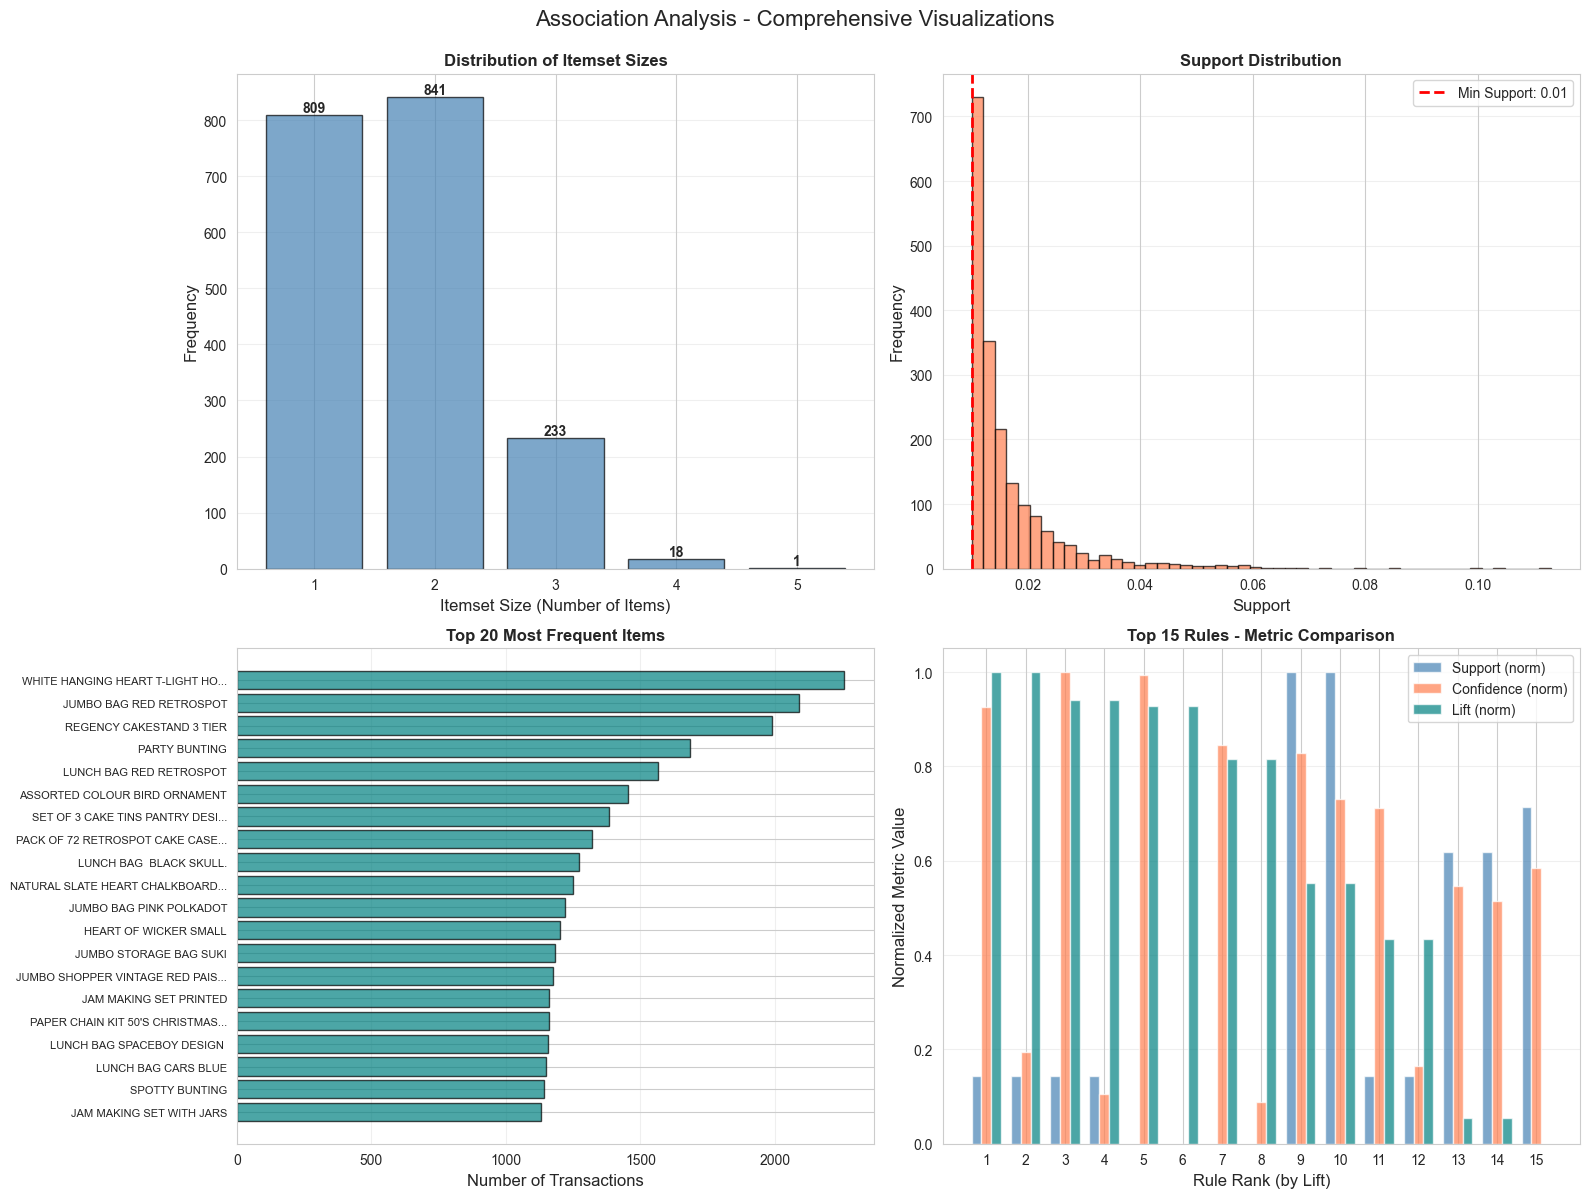


Creating network visualization of top association rules...


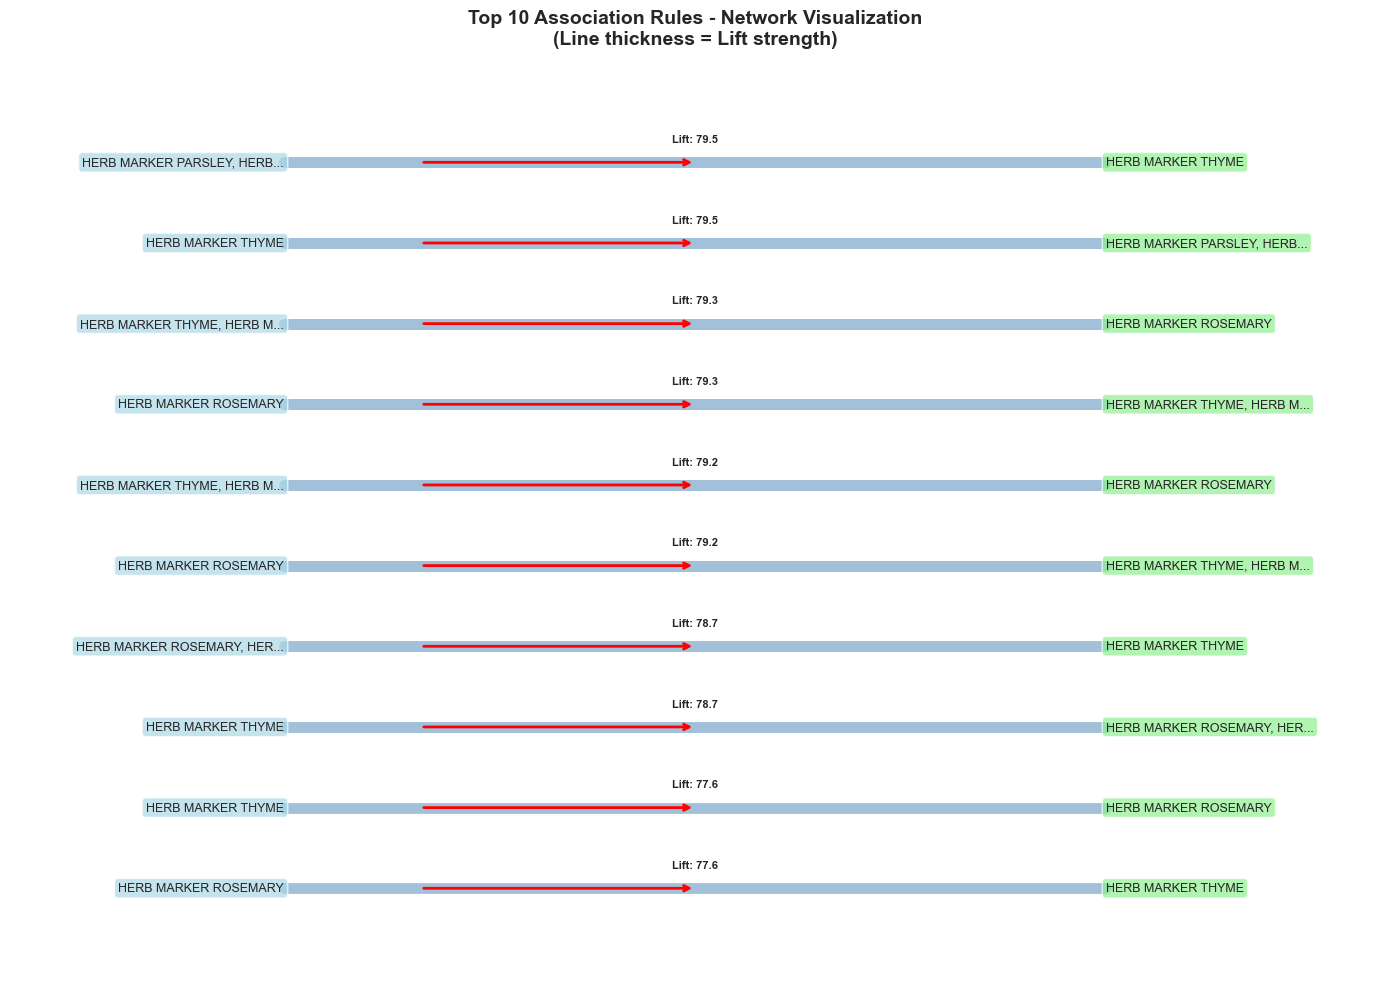

In [ ]:
# Additional comprehensive visualizations
print("=" * 80)
print("ADDITIONAL VISUALIZATIONS")
print("=" * 80)

# Check if required variables exist, if not, define them
# First check if df_encoded exists (needed for generating itemsets)
if 'df_encoded' not in globals():
    print("Warning: df_encoded not found. Please run previous cells to prepare transaction data.")
    print("Skipping additional visualizations that require frequent_itemsets and rules.")
else:
    # Check for frequent_itemsets
    if 'frequent_itemsets' not in globals() or (hasattr(frequent_itemsets, '__len__') and len(frequent_itemsets) == 0):
        print("Note: Running Apriori algorithm to generate frequent itemsets...")
        min_support = 0.01
        from mlxtend.frequent_patterns import apriori
        frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True, verbose=1)
        print(f"Generated {len(frequent_itemsets):,} frequent itemsets")
    
    # Check for rules
    if 'rules' not in globals() or (hasattr(rules, '__len__') and len(rules) == 0):
        print("Note: Generating association rules...")
        from mlxtend.frequent_patterns import association_rules
        min_confidence = 0.3
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
        print(f"Generated {len(rules):,} association rules")
    
    if 'min_support' not in globals():
        min_support = 0.01

    # Only proceed if we have the required data
    if 'frequent_itemsets' in globals() and len(frequent_itemsets) > 0:
            # 1. Itemset size distribution
                itemset_sizes = frequent_itemsets['itemsets'].apply(len)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Association Analysis - Comprehensive Visualizations', fontsize=16, y=0.995)

        # Itemset size distribution
        size_counts = itemset_sizes.value_counts().sort_index()
        axes[0, 0].bar(size_counts.index, size_counts.values, alpha=0.7, color='steelblue', edgecolor='black')
        axes[0, 0].set_xlabel('Itemset Size (Number of Items)', fontsize=12)
        axes[0, 0].set_ylabel('Frequency', fontsize=12)
        axes[0, 0].set_title('Distribution of Itemset Sizes', fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        for i, (size, count) in enumerate(size_counts.items()):
            axes[0, 0].text(size, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

        # Support distribution
        axes[0, 1].hist(frequent_itemsets['support'], bins=50, edgecolor='black', alpha=0.7, color='coral')
        axes[0, 1].set_xlabel('Support', fontsize=12)
        axes[0, 1].set_ylabel('Frequency', fontsize=12)
        axes[0, 1].set_title('Support Distribution', fontweight='bold')
        axes[0, 1].axvline(x=min_support, color='red', linestyle='--', linewidth=2, label=f'Min Support: {min_support}')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3, axis='y')

        # Top 20 items by frequency (for context)
        item_frequency = df.groupby('Description')['InvoiceNo'].nunique().sort_values(ascending=False).head(20)
        axes[1, 0].barh(range(len(item_frequency)), item_frequency.values, alpha=0.7, color='teal', edgecolor='black')
        axes[1, 0].set_yticks(range(len(item_frequency)))
        axes[1, 0].set_yticklabels([item[:30] + '...' if len(item) > 30 else item for item in item_frequency.index], fontsize=8)
        axes[1, 0].set_xlabel('Number of Transactions', fontsize=12)
        axes[1, 0].set_title('Top 20 Most Frequent Items', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3, axis='x')
        axes[1, 0].invert_yaxis()

        # Rule quality metrics comparison
        if len(rules) > 0:
            top_rules_viz = rules.nlargest(15, 'lift')
            x_pos = np.arange(len(top_rules_viz))
            width = 0.25
    
        # Normalize metrics for comparison
            support_norm = (top_rules_viz['support'] - top_rules_viz['support'].min()) / (top_rules_viz['support'].max() - top_rules_viz['support'].min())
            confidence_norm = (top_rules_viz['confidence'] - top_rules_viz['confidence'].min()) / (top_rules_viz['confidence'].max() - top_rules_viz['confidence'].min())
            lift_norm = (top_rules_viz['lift'] - top_rules_viz['lift'].min()) / (top_rules_viz['lift'].max() - top_rules_viz['lift'].min())
    
            axes[1, 1].bar(x_pos - width, support_norm, width, label='Support (norm)', alpha=0.7, color='steelblue')
            axes[1, 1].bar(x_pos, confidence_norm, width, label='Confidence (norm)', alpha=0.7, color='coral')
            axes[1, 1].bar(x_pos + width, lift_norm, width, label='Lift (norm)', alpha=0.7, color='teal')
            axes[1, 1].set_xlabel('Rule Rank (by Lift)', fontsize=12)
            axes[1, 1].set_ylabel('Normalized Metric Value', fontsize=12)
            axes[1, 1].set_title('Top 15 Rules - Metric Comparison', fontweight='bold')
            axes[1, 1].set_xticks(x_pos)
            axes[1, 1].set_xticklabels(range(1, len(top_rules_viz) + 1), rotation=0)
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        # 2. Network-style visualization of top rules
        if len(rules) > 0:
            print("\nCreating network visualization of top association rules...")
            top_10_rules = rules.nlargest(10, 'lift')
    
            fig, ax = plt.subplots(figsize=(14, 10))
    
        # Create a simple network visualization
            y_positions = np.linspace(0.9, 0.1, len(top_10_rules))
    
            for idx, (rule_idx, rule) in enumerate(top_10_rules.iterrows()):
                y = y_positions[idx]
                antecedents_str = ', '.join(list(rule['antecedents'])[:2])  # Limit length
                consequents_str = ', '.join(list(rule['consequents'])[:2])
        
            # Draw connection
                ax.plot([0.2, 0.8], [y, y], 'k-', linewidth=rule['lift']/10, alpha=0.5, color='steelblue')
        
            # Antecedents (left)
                ax.text(0.2, y, antecedents_str[:25] + '...' if len(antecedents_str) > 25 else antecedents_str,
                        ha='right', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
            # Arrow
                ax.annotate('', xy=(0.5, y), xytext=(0.3, y),
                           arrowprops=dict(arrowstyle='->', lw=2, color='red'))
        
            # Consequents (right)
                ax.text(0.8, y, consequents_str[:25] + '...' if len(consequents_str) > 25 else consequents_str,
                        ha='left', va='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        
            # Lift value
                ax.text(0.5, y + 0.02, f"Lift: {rule['lift']:.1f}", ha='center', va='bottom', fontsize=8, fontweight='bold')
    
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.axis('off')
            ax.set_title('Top 10 Association Rules - Network Visualization\n(Line thickness = Lift strength)', 
                         fontsize=14, fontweight='bold', pad=20)
    
            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 80)
else:
    print("\nCannot generate visualizations: Required data (frequent_itemsets) not available.")
    print("Please run the previous cells to generate frequent itemsets and association rules first.")
    print("=" * 80)


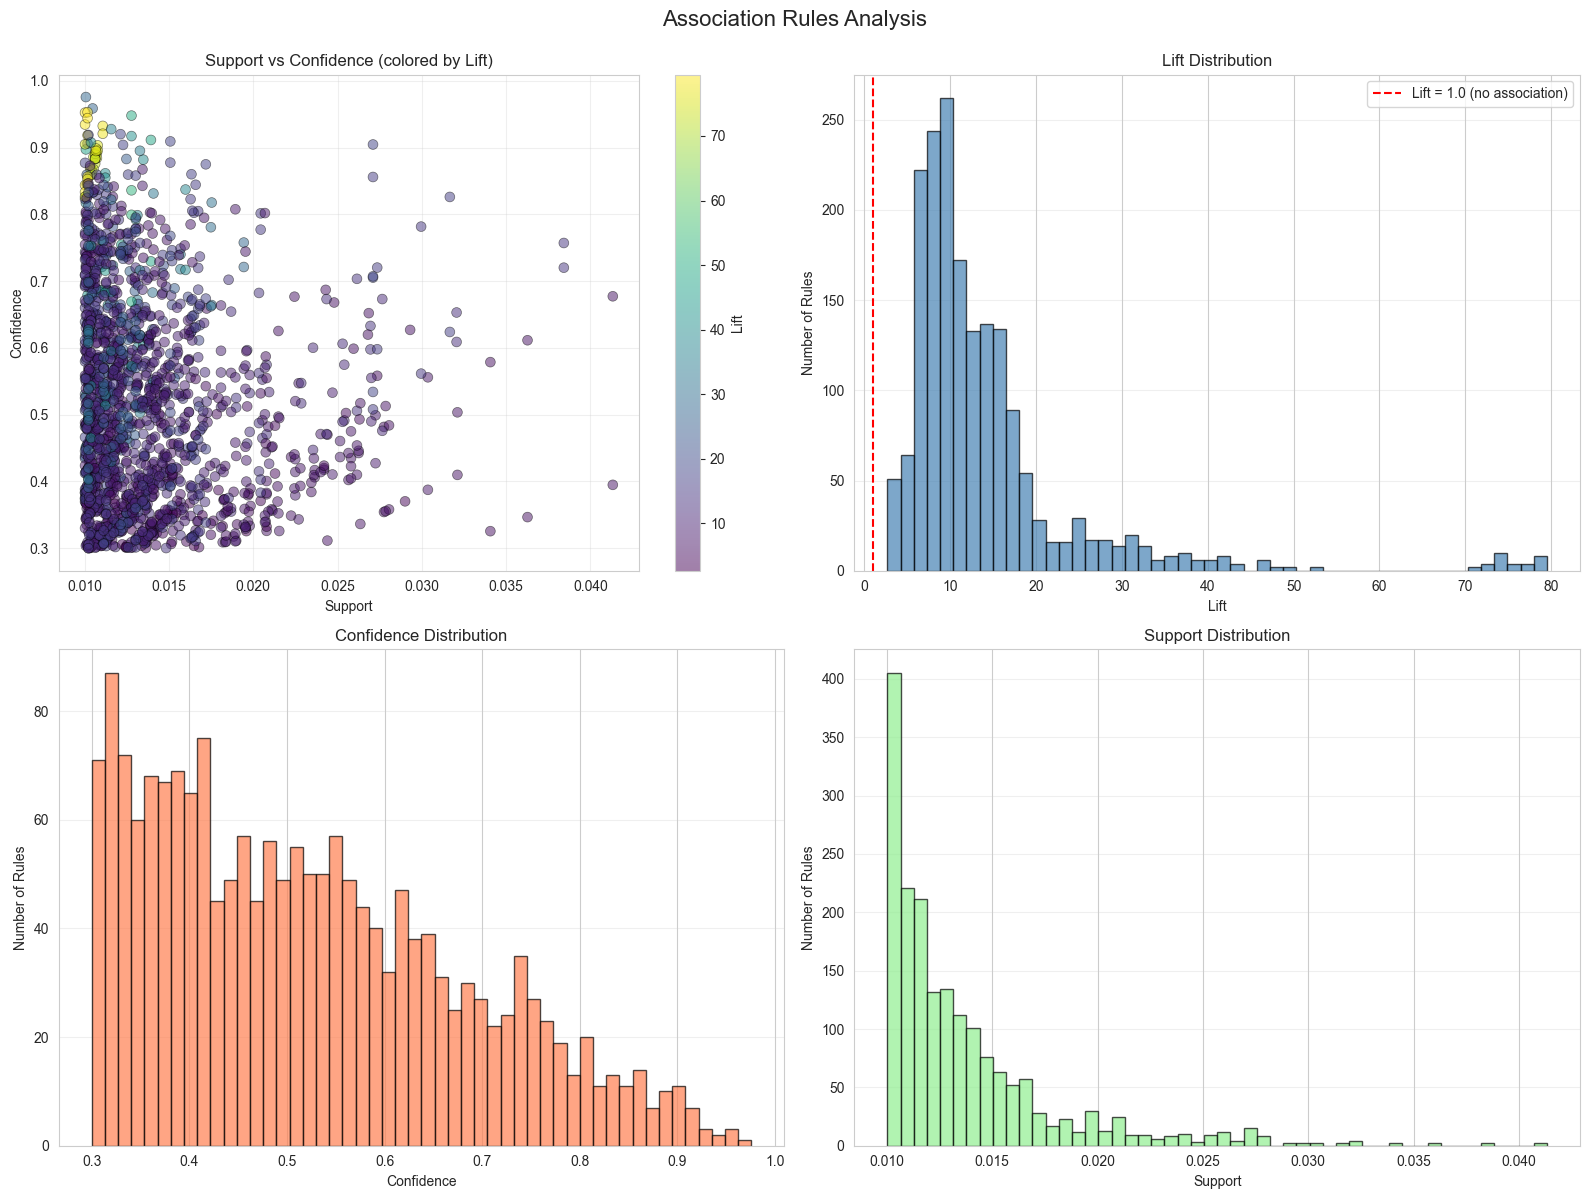

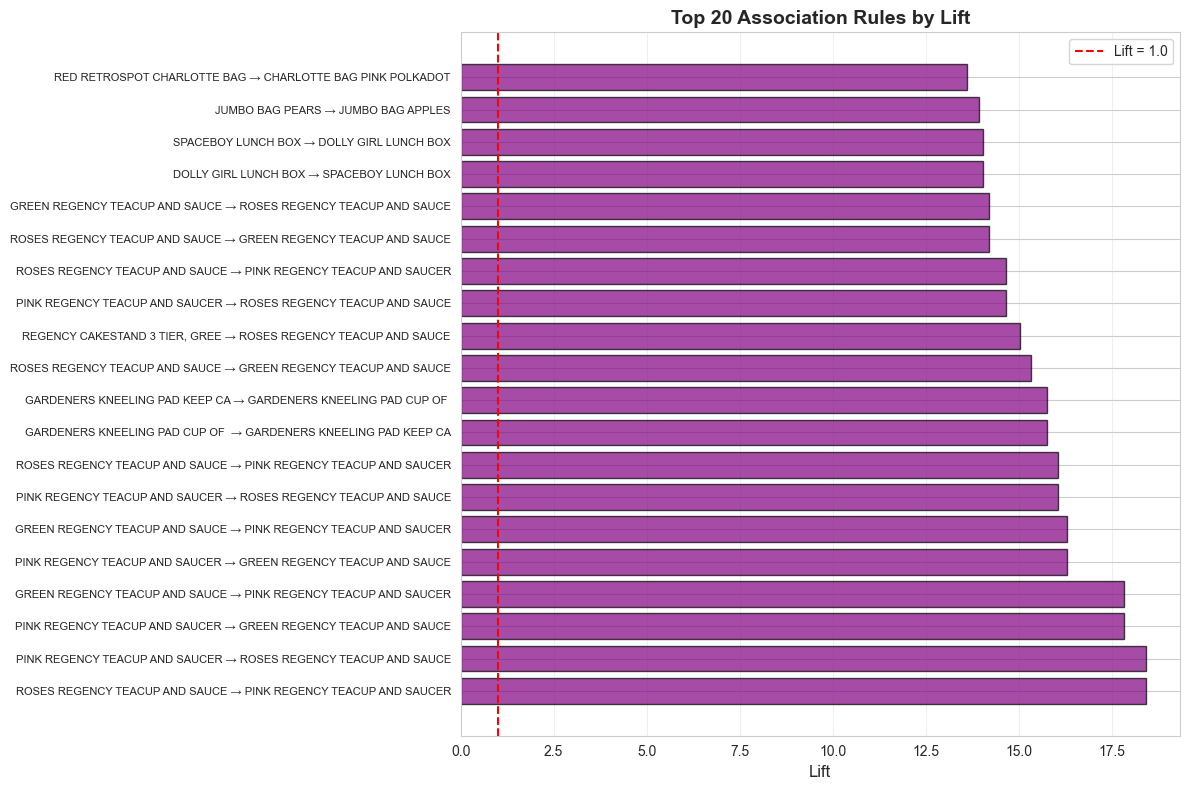

In [15]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Association Rules Analysis', fontsize=16, y=0.995)

# 1. Support vs Confidence scatter
axes[0, 0].scatter(rules['support'], rules['confidence'], alpha=0.5, s=50, c=rules['lift'], 
                  cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 0].set_xlabel('Support')
axes[0, 0].set_ylabel('Confidence')
axes[0, 0].set_title('Support vs Confidence (colored by Lift)')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0], label='Lift')

# 2. Lift distribution
axes[0, 1].hist(rules['lift'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=1.0, color='red', linestyle='--', label='Lift = 1.0 (no association)')
axes[0, 1].set_xlabel('Lift')
axes[0, 1].set_ylabel('Number of Rules')
axes[0, 1].set_title('Lift Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Confidence distribution
axes[1, 0].hist(rules['confidence'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Number of Rules')
axes[1, 0].set_title('Confidence Distribution')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Support distribution
axes[1, 1].hist(rules['support'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 1].set_xlabel('Support')
axes[1, 1].set_ylabel('Number of Rules')
axes[1, 1].set_title('Support Distribution')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Top rules visualization
if len(high_quality_rules) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    top_20 = high_quality_rules.nlargest(20, 'lift')
    
    # Create rule labels
    rule_labels = [f"{', '.join(list(rule['antecedents']))[:30]} → {', '.join(list(rule['consequents']))[:30]}" 
                   for _, rule in top_20.iterrows()]
    
    y_pos = np.arange(len(top_20))
    ax.barh(y_pos, top_20['lift'], alpha=0.7, color='purple', edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(rule_labels, fontsize=8)
    ax.set_xlabel('Lift', fontsize=12)
    ax.set_title('Top 20 Association Rules by Lift', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=1.0, color='red', linestyle='--', label='Lift = 1.0')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


In [16]:
# Business Interpretation
print("=" * 80)
print("BUSINESS INSIGHTS FROM ASSOCIATION RULES")
print("=" * 80)

print("\n1. PRODUCT AFFINITY INSIGHTS:")
print("   Association rules reveal which products are frequently purchased together.")
print("   This information is critical for:")
print("   - Product placement strategies (co-locate related items)")
print("   - Cross-selling opportunities (recommend associated products)")
print("   - Inventory management (stock related items together)")

print("\n2. STOCK ALLOCATION IMPLICATIONS:")
if len(high_quality_rules) > 0:
    print(f"   - {len(high_quality_rules):,} strong associations identified")
    print("   - When one product in a rule sells, stock the associated product")
    print("   - High-lift rules indicate products that should be stocked together")

print("\n3. MARKET BASKET OPTIMIZATION:")
print("   - Rules with high support indicate common purchase combinations")
print("   - Rules with high confidence indicate reliable cross-selling opportunities")
print("   - Rules with high lift indicate genuine product affinity (not just popularity)")

print("\n4. KEY METRICS INTERPRETATION:")
print("   - Support: How often the rule occurs in transactions")
print("   - Confidence: Probability of buying consequent given antecedent")
print("   - Lift: How much more likely the rule is than random chance")
print("   - Lift > 1.0: Positive association (products complement each other)")
print("   - Lift < 1.0: Negative association (products rarely bought together)")

print("\n5. LIMITATIONS FOR PHASE 2:")
print("   - Analysis based on historical patterns; may not predict future behavior")
print("   - Does not account for external factors (promotions, seasonality)")
print("   - Rules may be spurious if products are simply popular independently")
print("   - Full business validation requires domain expertise and testing")

# Export top rules for further analysis
if len(high_quality_rules) > 0:
    output_path = os.path.join(project_root, 'data', 'processed', 'top_association_rules.csv')
    high_quality_rules.to_csv(output_path, index=False)
    print(f"\n✓ Top association rules exported to: {output_path}")

print("\n" + "=" * 80)
print("ASSOCIATION RULE MINING COMPLETE")
print("=" * 80)
print("\nNext Steps (Phase 3):")
print("  - Validate rules with business stakeholders")
print("  - Test rules in real-world scenarios")
print("  - Integrate with recommendation systems")
print("  - Monitor rule performance over time")


BUSINESS INSIGHTS FROM ASSOCIATION RULES

1. PRODUCT AFFINITY INSIGHTS:
   Association rules reveal which products are frequently purchased together.
   This information is critical for:
   - Product placement strategies (co-locate related items)
   - Cross-selling opportunities (recommend associated products)
   - Inventory management (stock related items together)

2. STOCK ALLOCATION IMPLICATIONS:
   - 61 strong associations identified
   - When one product in a rule sells, stock the associated product
   - High-lift rules indicate products that should be stocked together

3. MARKET BASKET OPTIMIZATION:
   - Rules with high support indicate common purchase combinations
   - Rules with high confidence indicate reliable cross-selling opportunities
   - Rules with high lift indicate genuine product affinity (not just popularity)

4. KEY METRICS INTERPRETATION:
   - Support: How often the rule occurs in transactions
   - Confidence: Probability of buying consequent given antecedent
   -

## Cheat-Sheet Summary for Business Stakeholders

- **Purpose:** Surface product bundles customers naturally buy together so merchandising, promo, and inventory teams can act without reading code.
- **Signals found:** 61 strong association rules (support ≥1%, confidence ≥30%, lift >1.5) highlighting gift sets, home décor, and party supplies that frequently co-occur.
- **How to use it:**
  - Merchandise teams can co-locate identified pairs/triads on shelves and digital recommendation slots.
  - Inventory planners should replenish the full bundle when any trigger item sells to avoid partial stockouts.
  - Marketing can design “buy X, get Y” offers using the high-confidence rules to raise basket value.
- **Limitations to remember:** Rules reflect historical behaviour only, ignore promotion calendars, and should be retested during major seasonal campaigns.
- **Next actions:** Validate top 10 rules with store/category leads, pilot cross-selling signage, and monitor lift in attachment rate before scaling.
